In [2]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from keras import backend as K 


from IAdeforestation.preprocessing import *
from IAdeforestation.training import *

np.random.seed(42)

Using TensorFlow backend.


In [3]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2604018690859034081
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3172404430
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9080440098011686193
physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [4]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'transfer_learning')
#IMAGES_DIR = 'D:\\fall_images' # For 64x64 images
IMAGES_DIR = 'images'
#IMAGES_DIR = 'D:\img32' # For 32x32 images

In [4]:
base_model = DenseNet(include_top=False,
                          weights=None,
                          input_shape=(64, 64, 13))

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
predictions = Dense(10, activation='softmax')(top_model)
source_model = Model(inputs=base_model.input, outputs=predictions)
source_model.load_weights("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5")

C:\Users\romain.capocasa\.conda\envs\keras_gpu\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  str(input_shape[-1]) + ' input channels.')


In [5]:
source_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block28_0_relu (Activatio (None, 2, 2, 1760)   0           conv5_block28_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block28_1_conv (Conv2D)   (None, 2, 2, 128)    225280      conv5_block28_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block28_1_bn (BatchNormal (None, 2, 2, 128)    512         conv5_block28_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block28_1_relu (Activatio (None, 2, 2, 128)    0           conv5_block28_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block28_2_conv (Conv2D)   (None, 2, 2, 32)     36864       conv5_block28_1_relu[0][0]       
__________

In [6]:
# Set layers as non trainable
for k,v in source_model._get_trainable_state().items():
    k.trainable = False

# Coffee vs other
### Without Globale Pooling

In [7]:
# Add new layer to pre-trained network
flat1 = Flatten()(source_model.layers[-3].output)
dropout_flatten = Dropout(0.5)(flat1)

dense256 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
dropout256 = Dropout(0.5)(dense256)

dense32 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout256)
dropout32 = Dropout(0.5)(dense32)

output = Dense(1, activation='sigmoid')(dropout32)

final_model = Model(inputs=base_model.input, outputs=output)

### With Globale Pooling

In [ ]:
# Add new layer to pre-trained network
pooling = GlobalAveragePooling2D()(source_model.layers[-3].output)
dropout_pooling = Dropout(0.5)(pooling)

dense2048 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_pooling)
droupout2048 = Dropout(0.5)(dense2048)

output = Dense(1, activation='sigmoid')(droupout2048)

final_model = Model(inputs=base_model.input, outputs=output)

In [8]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block28_2_conv (Conv2D)   (None, 2, 2, 32)     36864       conv5_block28_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block28_concat (Concatena (None, 2, 2, 1792)   0           conv5_block27_concat[0][0]       
                                                                 conv5_block28_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block29_0_bn (BatchNormal (None, 2, 2, 1792)   7168        conv5_block28_concat[0][0]       
__________________________________________________________________________________________________
conv5_block29_0_relu (Activatio (None, 2, 2, 1792)   0           conv5_block29_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

### Run only for modify input shape

In [ ]:
final_model = change_model(final_model, new_input_shape=(None, 32,32,13))
final_model.summary()

In [9]:
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
class1 = [0]*len(path1)

In [10]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
    
class2 = [1]*len(path2)

In [11]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)

In [25]:
BATCH_SIZE = 64

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.33, random_state=42)
train_generator = generator(path_train, 
                            y_train, 
                            vietnam_params['mean'], 
                            vietnam_params['std'], 
                            batch_size=BATCH_SIZE, 
                            is_data_augmentation=True)

test_generator = generator(path_test, 
                           y_test, 
                           vietnam_params['mean'], 
                           vietnam_params['std'], 
                           batch_size=BATCH_SIZE, 
                           is_data_augmentation=True)

In [26]:
RUN_NAME = 'trans_learning_viet_params'
LOGS_PATH = 'logs'


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [27]:
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3

final_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = final_model.fit(train_generator,
                        epochs=100,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 123 steps, validate for 60 steps
Epoch 1/100
123/123 [==============================] - 172s 1s/step - loss: 1.1119 - accuracy: 0.5050 - val_loss: 0.9813 - val_accuracy: 0.4969
Epoch 2/100
123/123 [==============================] - 147s 1s/step - loss: 1.0110 - accuracy: 0.5395 - val_loss: 0.9745 - val_accuracy: 0.4781
Epoch 3/100
123/123 [==============================] - 147s 1s/step - loss: 0.9618 - accuracy: 0.5708 - val_loss: 0.9616 - val_accuracy: 0.4794
Epoch 4/100
123/123 [==============================] - 147s 1s/step - loss: 0.9391 - accuracy: 0.6033 - val_loss: 0.9493 - val_accuracy: 0.4909
Epoch 5/100
123/123 [==============================] - 146s 1s/step - loss: 0.9111 - accuracy: 0.6128 - val_loss: 0.9394 - val_accuracy: 0.4951
Epoch 6/100
123/123 [==============================] - 146s 1s/step - loss: 0.8832 - accuracy: 0.6297 - val_loss: 0.9299 - val_accuracy: 0.5016
Epoch 7/100
123/123 [==============================] - 146s 1s/step - loss: 0.8727 - accuracy

In [28]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))

final_model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.npy'),history.history)

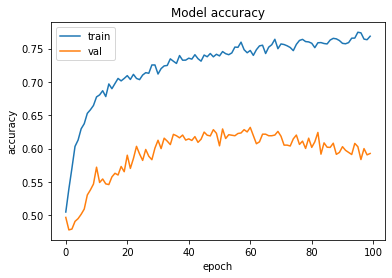

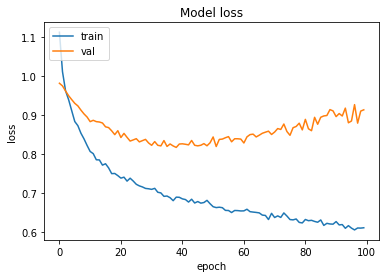

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
final_model.evaluate_generator(test_generator,30)

[0.6172418137391408, 0.7651042]

In [32]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(final_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [33]:
cm = confusion_matrix(Y_true, Y_pred)

In [34]:
cm

array([[944,  43],
       [473, 460]], dtype=int64)

In [35]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.67      0.96      0.79       987
           1       0.91      0.49      0.64       933

    accuracy                           0.73      1920
   macro avg       0.79      0.72      0.71      1920
weighted avg       0.79      0.73      0.72      1920

F1-Score : 0.6406685236768802


## Culture vs no culture

In [10]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

nb_culture = 0
for c in culture_list:
    nb_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

nb_no_culture = 0
for c in no_culture_list:
    nb_no_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

In [11]:
path_culture = []

for c in culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_culture.append(os.path.join(IMAGES_DIR, str(c), name))
class_culture = [0]*len(path_culture)
        
path_no_culture = []

for c in no_culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_no_culture.append(os.path.join(IMAGES_DIR, str(c), name))
class_no_culture = [1]*len(path_no_culture)

In [12]:
BATCH_SIZE = 64

file_paths = np.asarray(path_culture + path_no_culture)
classes = np.asarray(class_culture + class_no_culture)

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.25, random_state=42)
train_generator = generator(path_train, y_train, vietnam_params['mean'], vietnam_params['std'], batch_size=BATCH_SIZE)
test_generator = generator(path_test, y_test, vietnam_params['mean'], vietnam_params['std'], batch_size=BATCH_SIZE)

In [13]:
# Add new layer to pre-trained network
flat1 = Flatten()(source_model.layers[-3].output)
dropout_flatten = Dropout(0.5)(flat1)

dense256 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
dropout256 = Dropout(0.5)(dense256)

dense32 = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout256)
dropout32 = Dropout(0.5)(dense32)

output = Dense(1, activation='sigmoid')(dropout32)

model_culture = Model(inputs=base_model.input, outputs=output)

In [14]:
model_culture.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block24_1_bn (BatchNormal (None, 2, 2, 128)    512         conv5_block24_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_relu (Activatio (None, 2, 2, 128)    0           conv5_block24_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block24_2_conv (Conv2D)   (None, 2, 2, 32)     36864       conv5_block24_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block24_concat (Concatena (None, 2, 2, 1664)   0           conv5_block23_concat[0][0]       
                                                                 conv5_block24_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_bloc

In [16]:
# Run only for modify input shape
model_culture = change_model(model_culture, new_input_shape=(None, 32,32,13))
model_culture.summary()

Loaded layer input_1
Loaded layer zero_padding2d
Loaded layer conv1/conv
Loaded layer conv1/bn
Loaded layer conv1/relu
Loaded layer zero_padding2d_1
Loaded layer pool1
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_0_relu
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_concat
Loaded layer conv2_block2_0_bn
Loaded layer conv2_block2_0_relu
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_concat
Loaded layer conv2_block3_0_bn
Loaded layer conv2_block3_0_relu
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded layer conv2_block3_concat
Loaded layer conv2_block4_0_bn
Loaded layer conv2_block4_0_relu
Loaded layer conv2_block4_1_conv
Loaded layer conv2_block4_1_bn
Loaded layer conv2_bloc

Loaded layer conv4_block23_concat
Loaded layer conv4_block24_0_bn
Loaded layer conv4_block24_0_relu
Loaded layer conv4_block24_1_conv
Loaded layer conv4_block24_1_bn
Loaded layer conv4_block24_1_relu
Loaded layer conv4_block24_2_conv
Loaded layer conv4_block24_concat
Loaded layer conv4_block25_0_bn
Loaded layer conv4_block25_0_relu
Loaded layer conv4_block25_1_conv
Loaded layer conv4_block25_1_bn
Loaded layer conv4_block25_1_relu
Loaded layer conv4_block25_2_conv
Loaded layer conv4_block25_concat
Loaded layer conv4_block26_0_bn
Loaded layer conv4_block26_0_relu
Loaded layer conv4_block26_1_conv
Loaded layer conv4_block26_1_bn
Loaded layer conv4_block26_1_relu
Loaded layer conv4_block26_2_conv
Loaded layer conv4_block26_concat
Loaded layer conv4_block27_0_bn
Loaded layer conv4_block27_0_relu
Loaded layer conv4_block27_1_conv
Loaded layer conv4_block27_1_bn
Loaded layer conv4_block27_1_relu
Loaded layer conv4_block27_2_conv
Loaded layer conv4_block27_concat
Loaded layer conv4_block28_0_b

Loaded layer conv5_block17_concat
Loaded layer conv5_block18_0_bn
Loaded layer conv5_block18_0_relu
Loaded layer conv5_block18_1_conv
Loaded layer conv5_block18_1_bn
Loaded layer conv5_block18_1_relu
Loaded layer conv5_block18_2_conv
Loaded layer conv5_block18_concat
Loaded layer conv5_block19_0_bn
Loaded layer conv5_block19_0_relu
Loaded layer conv5_block19_1_conv
Loaded layer conv5_block19_1_bn
Loaded layer conv5_block19_1_relu
Loaded layer conv5_block19_2_conv
Loaded layer conv5_block19_concat
Loaded layer conv5_block20_0_bn
Loaded layer conv5_block20_0_relu
Loaded layer conv5_block20_1_conv
Loaded layer conv5_block20_1_bn
Loaded layer conv5_block20_1_relu
Loaded layer conv5_block20_2_conv
Loaded layer conv5_block20_concat
Loaded layer conv5_block21_0_bn
Loaded layer conv5_block21_0_relu
Loaded layer conv5_block21_1_conv
Loaded layer conv5_block21_1_bn
Loaded layer conv5_block21_1_relu
Loaded layer conv5_block21_2_conv
Loaded layer conv5_block21_concat
Loaded layer conv5_block22_0_b

__________________________________________________________________________________________________
conv4_block15_0_bn (BatchNormal (None, 2, 2, 704)    2816        conv4_block14_concat[0][0]       
__________________________________________________________________________________________________
conv4_block15_0_relu (Activatio (None, 2, 2, 704)    0           conv4_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_1_conv (Conv2D)   (None, 2, 2, 128)    90112       conv4_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_bn (BatchNormal (None, 2, 2, 128)    512         conv4_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_relu (Activatio (None, 2, 2, 128)    0           conv4_block15_1_bn[0][0]         
__________

In [16]:
RUN_NAME = 'transfer_culture_vietnam_params'
LOGS_PATH = 'logs'
#os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [17]:
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 2

model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model_culture.fit(train_generator,
                        epochs=100,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 174 steps, validate for 58 steps
Epoch 1/100
174/174 [==============================] - 214s 1s/step - loss: 0.8779 - accuracy: 0.5383 - val_loss: 0.8244 - val_accuracy: 0.5124
Epoch 2/100
174/174 [==============================] - 195s 1s/step - loss: 0.8016 - accuracy: 0.5812 - val_loss: 0.8149 - val_accuracy: 0.5218
Epoch 3/100
174/174 [==============================] - 198s 1s/step - loss: 0.7649 - accuracy: 0.6170 - val_loss: 0.8053 - val_accuracy: 0.5404
Epoch 4/100
174/174 [==============================] - 199s 1s/step - loss: 0.7391 - accuracy: 0.6386 - val_loss: 0.7927 - val_accuracy: 0.5727
Epoch 5/100
174/174 [==============================] - 194s 1s/step - loss: 0.7180 - accuracy: 0.6580 - val_loss: 0.7844 - val_accuracy: 0.6010
Epoch 6/100
174/174 [==============================] - 196s 1s/step - loss: 0.6986 - accuracy: 0.6722 - val_loss: 0.7725 - val_accuracy: 0.6253
Epoch 7/100
174/174 [==============================] - 192s 1s/step - loss: 0.6812 - accuracy

In [18]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

model_culture.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.npy'),history.history)

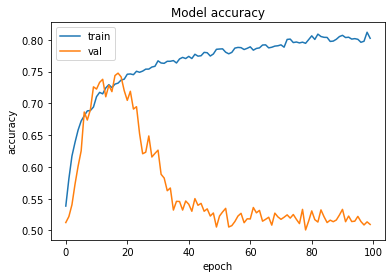

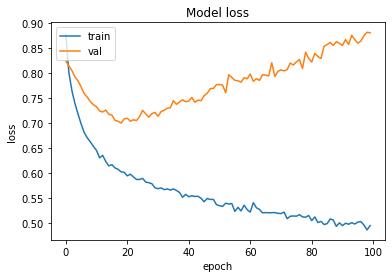

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
test_generator = generator(path_test, y_test, eurosat_params['mean'], eurosat_params['std'], batch_size=BATCH_SIZE)
model_culture.evaluate_generator(test_generator,30)

[0.46674337685108186, 0.8041667]

In [42]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model_culture.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [43]:
cm = confusion_matrix(Y_true, Y_pred)

In [44]:
cm

array([[843, 212],
       [237, 628]], dtype=int64)

In [45]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1055
           1       0.75      0.73      0.74       865

    accuracy                           0.77      1920
   macro avg       0.76      0.76      0.76      1920
weighted avg       0.77      0.77      0.77      1920

F1-Score : 0.7366568914956012


# Change input

In [6]:
base_model = DenseNet(include_top=False,
                          weights=None,
                          input_shape=(64, 64, 13))

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
predictions = Dense(10, activation='softmax')(top_model)
source_model = Model(inputs=base_model.input, outputs=predictions)
source_model.load_weights("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5")

C:\Users\romain.capocasa\.conda\envs\keras_gpu\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  str(input_shape[-1]) + ' input channels.')


In [8]:
new_model = change_model(source_model, new_input_shape=(None, 32,32,13))
new_model.summary()

Loaded layer input_1
Loaded layer zero_padding2d
Loaded layer conv1/conv
Loaded layer conv1/bn
Loaded layer conv1/relu
Loaded layer zero_padding2d_1
Loaded layer pool1
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_0_relu
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_concat
Loaded layer conv2_block2_0_bn
Loaded layer conv2_block2_0_relu
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_concat
Loaded layer conv2_block3_0_bn
Loaded layer conv2_block3_0_relu
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded layer conv2_block3_concat
Loaded layer conv2_block4_0_bn
Loaded layer conv2_block4_0_relu
Loaded layer conv2_block4_1_conv
Loaded layer conv2_block4_1_bn
Loaded layer conv2_bloc

Loaded layer conv4_block23_1_relu
Loaded layer conv4_block23_2_conv
Loaded layer conv4_block23_concat
Loaded layer conv4_block24_0_bn
Loaded layer conv4_block24_0_relu
Loaded layer conv4_block24_1_conv
Loaded layer conv4_block24_1_bn
Loaded layer conv4_block24_1_relu
Loaded layer conv4_block24_2_conv
Loaded layer conv4_block24_concat
Loaded layer conv4_block25_0_bn
Loaded layer conv4_block25_0_relu
Loaded layer conv4_block25_1_conv
Loaded layer conv4_block25_1_bn
Loaded layer conv4_block25_1_relu
Loaded layer conv4_block25_2_conv
Loaded layer conv4_block25_concat
Loaded layer conv4_block26_0_bn
Loaded layer conv4_block26_0_relu
Loaded layer conv4_block26_1_conv
Loaded layer conv4_block26_1_bn
Loaded layer conv4_block26_1_relu
Loaded layer conv4_block26_2_conv
Loaded layer conv4_block26_concat
Loaded layer conv4_block27_0_bn
Loaded layer conv4_block27_0_relu
Loaded layer conv4_block27_1_conv
Loaded layer conv4_block27_1_bn
Loaded layer conv4_block27_1_relu
Loaded layer conv4_block27_2_c

Loaded layer conv5_block13_1_relu
Loaded layer conv5_block13_2_conv
Loaded layer conv5_block13_concat
Loaded layer conv5_block14_0_bn
Loaded layer conv5_block14_0_relu
Loaded layer conv5_block14_1_conv
Loaded layer conv5_block14_1_bn
Loaded layer conv5_block14_1_relu
Loaded layer conv5_block14_2_conv
Loaded layer conv5_block14_concat
Loaded layer conv5_block15_0_bn
Loaded layer conv5_block15_0_relu
Loaded layer conv5_block15_1_conv
Loaded layer conv5_block15_1_bn
Loaded layer conv5_block15_1_relu
Loaded layer conv5_block15_2_conv
Loaded layer conv5_block15_concat
Loaded layer conv5_block16_0_bn
Loaded layer conv5_block16_0_relu
Loaded layer conv5_block16_1_conv
Loaded layer conv5_block16_1_bn
Loaded layer conv5_block16_1_relu
Loaded layer conv5_block16_2_conv
Loaded layer conv5_block16_concat
Loaded layer conv5_block17_0_bn
Loaded layer conv5_block17_0_relu
Loaded layer conv5_block17_1_conv
Loaded layer conv5_block17_1_bn
Loaded layer conv5_block17_1_relu
Loaded layer conv5_block17_2_c

conv5_block10_0_bn (BatchNormal (None, 1, 1, 1184)   4736        conv5_block9_concat[0][0]        
__________________________________________________________________________________________________
conv5_block10_0_relu (Activatio (None, 1, 1, 1184)   0           conv5_block10_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block10_1_conv (Conv2D)   (None, 1, 1, 128)    151552      conv5_block10_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block10_1_bn (BatchNormal (None, 1, 1, 128)    512         conv5_block10_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block10_1_relu (Activatio (None, 1, 1, 128)    0           conv5_block10_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

In [9]:
for k,v in new_model._get_trainable_state().items():
    k.trainable = False

In [10]:
# Add new layer to pre-trained network
flat1 = Flatten()(new_model.layers[-3].output)
dropout_flatten = Dropout(0.5)(flat1)

dense256 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
dropout256 = Dropout(0.5)(dense256)

dense32 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout256)
dropout32 = Dropout(0.5)(dense32)

output = Dense(1, activation='sigmoid')(dropout32)

final_model = Model(inputs=new_model.input, outputs=output)

In [11]:
IMAGES_DIR = 'D:\img32'
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
class1 = [0]*len(path1)

In [12]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
    
class2 = [1]*len(path2)

In [13]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)

In [14]:
BATCH_SIZE = 64

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.33)
train_generator = generator(path_train, y_train, eurosat_mean, eurosat_std, batch_size=BATCH_SIZE, is_data_augmentation=True)
test_generator = generator(path_test, y_test, eurosat_mean, eurosat_std, batch_size=BATCH_SIZE, is_data_augmentation=True)

In [15]:
RUN_NAME = '32x32transfer'
LOGS_PATH = 'logs'


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

In [16]:
LEARNING_RATE = 0.00005
DATA_AUGMENTATION_MULTIPLIATOR = 2

final_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = final_model.fit(train_generator,
                        epochs=100,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 166 steps, validate for 82 steps
Epoch 1/100
166/166 [==============================] - 417s 3s/step - loss: 0.9891 - accuracy: 0.5405 - val_loss: 0.9175 - val_accuracy: 0.6681
Epoch 2/100
166/166 [==============================] - 193s 1s/step - loss: 0.8996 - accuracy: 0.6072 - val_loss: 0.8669 - val_accuracy: 0.6776
Epoch 3/100
166/166 [==============================] - 167s 1s/step - loss: 0.8482 - accuracy: 0.6371 - val_loss: 0.8257 - val_accuracy: 0.6894
Epoch 4/100
166/166 [==============================] - 207s 1s/step - loss: 0.8148 - accuracy: 0.6537 - val_loss: 0.7964 - val_accuracy: 0.6966
Epoch 5/100
166/166 [==============================] - 248s 1s/step - loss: 0.7852 - accuracy: 0.6725 - val_loss: 0.7802 - val_accuracy: 0.6869
Epoch 6/100
166/166 [==============================] - 235s 1s/step - loss: 0.7673 - accuracy: 0.6721 - val_loss: 0.7677 - val_accuracy: 0.6858
Epoch 7/100
166/166 [==============================] - 211s 1s/step - loss: 0.7489 - accuracy

In [16]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

final_model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '.npy'),history.history)

NameError: name 'final_model' is not defined

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


NameError: name 'history' is not defined

# Performance 64x64 vs 32x32
## Coffee

In [4]:
history32 = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','32x32transfer', '32x32transfer.npy'),allow_pickle='TRUE').item()
history64 = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

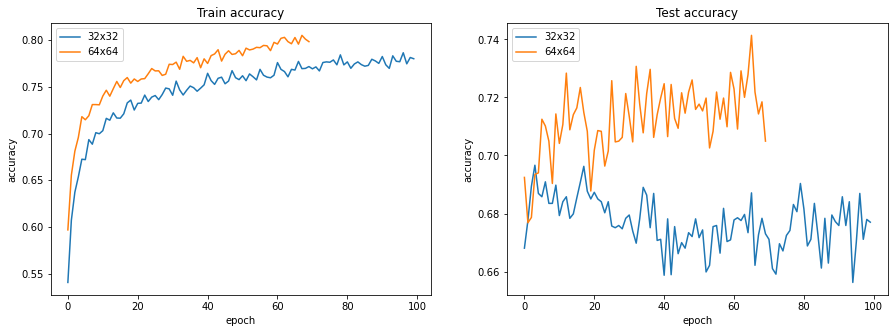

In [6]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['accuracy'])
axes[0].plot(history64['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_accuracy'])
axes[1].plot(history64['val_accuracy'])
axes[1].set_title('Test accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

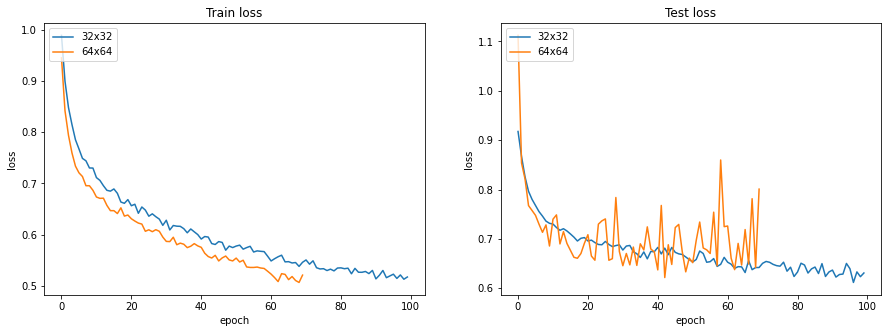

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['loss'])
axes[0].plot(history64['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_loss'])
axes[1].plot(history64['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

## Culture vs no culture

In [12]:
history32 = np.load(os.path.join(SAVED_MODELS_PATH, 'Culture','32x32transfer_culture', '32x32transfer_culture.npy'),allow_pickle='TRUE').item()
history64 = np.load(os.path.join(SAVED_MODELS_PATH, 'Culture','transfer_learning_culture2', 'transfer_learning_culture2.npy'),allow_pickle='TRUE').item()

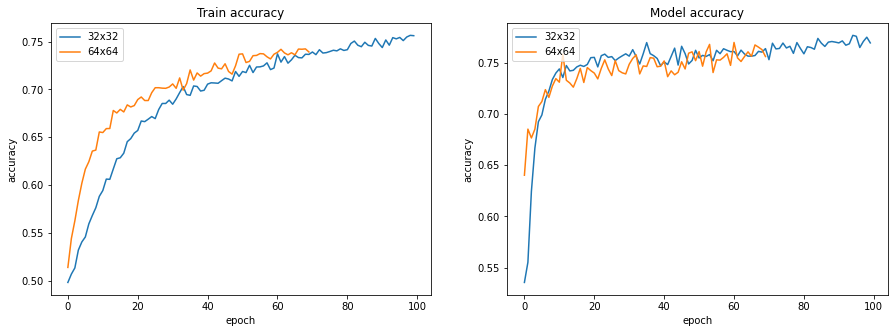

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['accuracy'])
axes[0].plot(history64['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_accuracy'])
axes[1].plot(history64['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

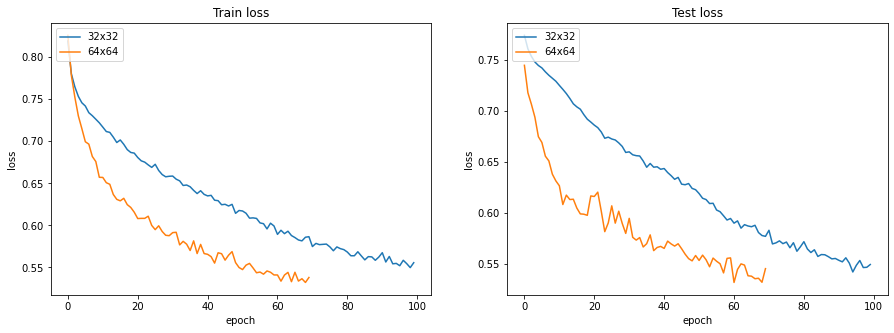

In [14]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['loss'])
axes[0].plot(history64['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_loss'])
axes[1].plot(history64['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

# Spring vs rest

In [18]:
history_fall = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','trans_learning_fall', 'trans_learning_fall.npy'),allow_pickle='TRUE').item()
history_base = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

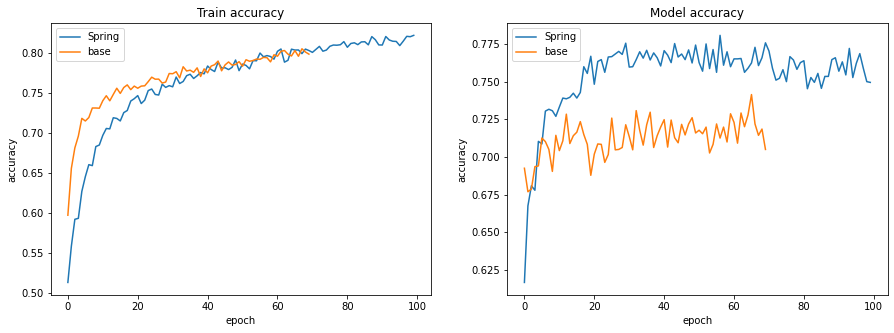

In [19]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_fall['accuracy'])
axes[0].plot(history_base['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['Spring', 'base'], loc='upper left')

axes[1].plot(history_fall['val_accuracy'])
axes[1].plot(history_base['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['Spring', 'base'], loc='upper left')

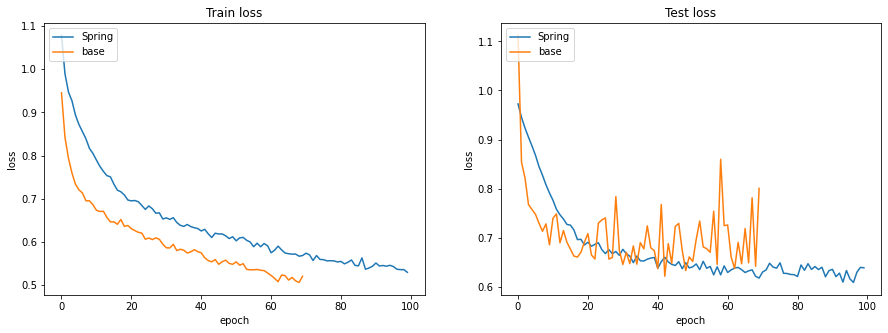

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_fall['loss'])
axes[0].plot(history_base['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['Spring', 'base'], loc='upper left')

axes[1].plot(history_fall['val_loss'])
axes[1].plot(history_base['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['Spring', 'base'], loc='upper left')

# Vietnam vs Eurosat

In [21]:
history_viet = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','trans_learning_viet_params', 'trans_learning_viet_params.npy'),allow_pickle='TRUE').item()
history_base = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()

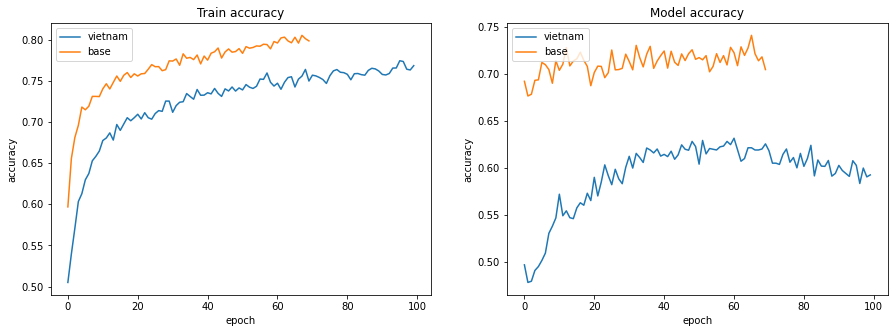

In [22]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_viet['accuracy'])
axes[0].plot(history_base['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['vietnam', 'base'], loc='upper left')

axes[1].plot(history_viet['val_accuracy'])
axes[1].plot(history_base['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['vietnam', 'base'], loc='upper left')

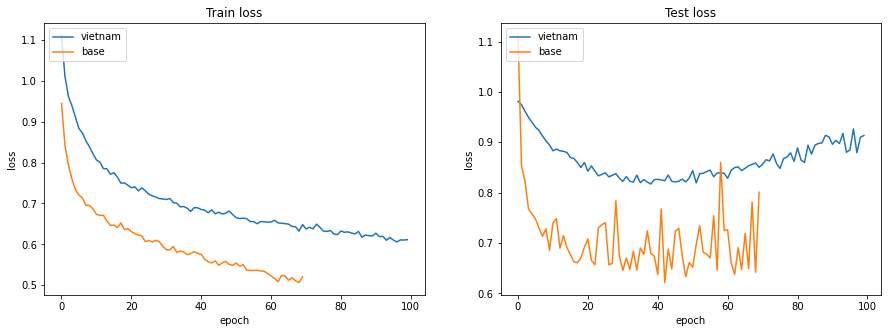

In [23]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_viet['loss'])
axes[0].plot(history_base['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['vietnam', 'base'], loc='upper left')

axes[1].plot(history_viet['val_loss'])
axes[1].plot(history_base['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['vietnam', 'base'], loc='upper left')